In [23]:
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta


In [24]:
auth.authenticate_user()

In [25]:
!gcloud config set project {'hackathon-352519'}

Updated property [core/project].


In [26]:
!gsutil cp gs://trains_data/train-data_all-train-events.zip /tmp/.

Copying gs://trains_data/train-data-2022062020220626.zip...
Copying gs://trains_data/train-data-master-2.zip...
Copying gs://trains_data/train-data-master.zip...
Copying gs://trains_data/train-data_all-train-events.zip...
| [4 files][828.4 MiB/828.4 MiB]   72.4 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://trains_data/train-events-20-min.zip...
/ [5 files][869.0 MiB/869.0 MiB]   72.2 MiB/s                                   
Operation completed over 5 objects/869.0 MiB.                                    


In [27]:
# z = zipfile.ZipFile('train-data_all-train-events.zip', 'r')

x = {}
trains = {}
i = 1
prevLoco = ''
with zipfile.ZipFile("/tmp/train-data_all-train-events.zip", "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if (prevLoco != currentLoco and "trainActualPositionList" in lastTrainReporting and "trainEstimatedPositionList" in lastTrainReporting and len(lastTrainReporting['trainEstimatedPositionList']) > 0):
                    trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    for position in trainActualPositionList:
                        positions = pd.json_normalize(position)
                        trains[i] = pd.json_normalize(lastTrainReporting)
                        x[i] = positions
                        i = i + 1
                        prevLoco = currentLoco
                            

In [28]:
df = pd.concat(x.values())
dfTrains = pd.concat(trains.values())

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   positionTime                                          1696 non-null   object 
 1   speedMPH                                              1696 non-null   int64  
 2   milepostLocation.subdivisionId                        1696 non-null   int64  
 3   milepostLocation.trackName                            1696 non-null   object 
 4   milepostLocation.milepost.milepostNumber              1696 non-null   float64
 5   nextSignalState.milepostLocation.milepostNumber       1106 non-null   float64
 6   nextSignalState.signalState                           1106 non-null   float64
 7   precedingSignalState.milepostLocation.milepostNumber  1166 non-null   float64
 8   precedingSignalState.previousSignalState              996 non

In [30]:
dfTrains.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 0 to 0
Data columns (total 44 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   ptcLeadLocomotiveId                                                        1696 non-null   object 
 1   maximumTrainSpeed                                                          1696 non-null   int64  
 2   loadedCarCount                                                             1696 non-null   int64  
 3   emptyCarCount                                                              1696 non-null   int64  
 4   trainLength                                                                1696 non-null   int64  
 5   trailingTonnage                                                            1696 non-null   int64  
 6   positionHistoryList                                        

# Step 1: Compute the accuracy of the Existing Physics BEoP model

In [31]:
dfTrains = dfTrains.drop_duplicates(subset=['ptcLeadLocomotiveId', 'trainId.trainSymbol', 'trainId.trainDate'], keep='first')
print(dfTrains.shape)


(38, 44)


In [32]:
def formatTrain(dfTrain):
  actuals = pd.json_normalize(dfTrain['trainActualPositionList'])
  cols = list(actuals.columns)
  dfx = (actuals[cols[0:2] + cols[3:5]])
  dfx = dfx.rename(columns={"speedMPH" : "speedMPH", "milepostLocation.trackName":"trackName", "milepostLocation.milepost.milepostNumber": "milepostNumber" })
  est = pd.json_normalize(dfTrain['trainEstimatedPositionList'])  
  beop = est.rename(columns={"speedMPH" : "forecastSpeedMPH", "milepostLocation.trackName":"forecastTrackName", "milepostLocation.milepost.milepostNumber": "forecastMilepostNumber" })
  joined = beop.join(dfx, lsuffix='_beop', rsuffix='_actual')
  dn = joined.dropna()
  dn = dn.loc[(dn['speedMPH'] != 0)]
  delta = abs(dn["speedMPH"] - dn["forecastSpeedMPH"]);
  dn = dn.apply(lambda x: abs(x) if x.name=='speedMPH' or  x.name=='forecastSpeedMPH' else x)
  dn["delta"] = delta
  dn['milepost'] = dn.apply(lambda row: math.trunc(row['milepostNumber']), axis=1)
  dn['millis'] = dn.apply(lambda row: ((datetime.strptime(row['positionTime_actual'], "%Y-%m-%dT%H:%M:%SZ"))  - datetime(1970, 1, 1)) // timedelta(milliseconds=1), axis=1)
  # dn = dn.reset_index()
  dn = dn.drop(columns=['milepostLocation.subdivisionId'])
  return dn

In [33]:
trains = []
for index, train in dfTrains.iterrows():
  trainId = train['trainId.trainSymbol']+" of "+train['trainId.trainDate']
  trains.append([trainId, formatTrain(train)])
trains[11]

['MCHCB of 2022-04-22',
        positionTime_beop  forecastSpeedMPH forecastTrackName  \
 0   2022-04-23T11:21:01Z                 8              MT 2   
 11  2022-04-23T11:43:01Z                49              MT 2   
 12  2022-04-23T11:45:01Z                50              MT 2   
 13  2022-04-23T11:47:01Z                50              MT 2   
 14  2022-04-23T11:49:01Z                50              MT 2   
 15  2022-04-23T11:51:01Z                50              MT 2   
 23  2022-04-23T12:07:01Z                40              MT 2   
 24  2022-04-23T12:09:01Z                40              MT 2   
 25  2022-04-23T12:11:01Z                42              MT 2   
 26  2022-04-23T12:13:01Z                44              MT 2   
 27  2022-04-23T12:15:01Z                46              MT 2   
 
     forecastMilepostNumber   positionTime_actual  speedMPH trackName  \
 0                202.20140  2022-04-23T11:23:01Z       2.0      MT 2   
 11               218.12735  2022-04-23T11:45:01

convert all data to positive values

In [34]:
def plotTrain(trainData):
  ax = plt.gca()
  trainDF = trainData[1]
  trainDF = trainDF.reset_index();
  trainDF.plot(x = 'milepostNumber', y="speedMPH", use_index=True, kind="scatter", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'milepostNumber', y="forecastSpeedMPH", use_index=True, kind="scatter", color="red", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'milepostNumber', y="delta", use_index=True, kind="line", color="green", ax=ax, figsize=[24,10])
  # plt.gcf().autofmt_xdate()
  (t,b)= ax.get_xlim()  ## Added for clarity
  if t < b:
    ax.set_xlim((b,t))
  plt.title(trainData[0])
  plt.show()

# Physics BEoP versus Actuals
red = physics model speed

blue = actual reported location speed

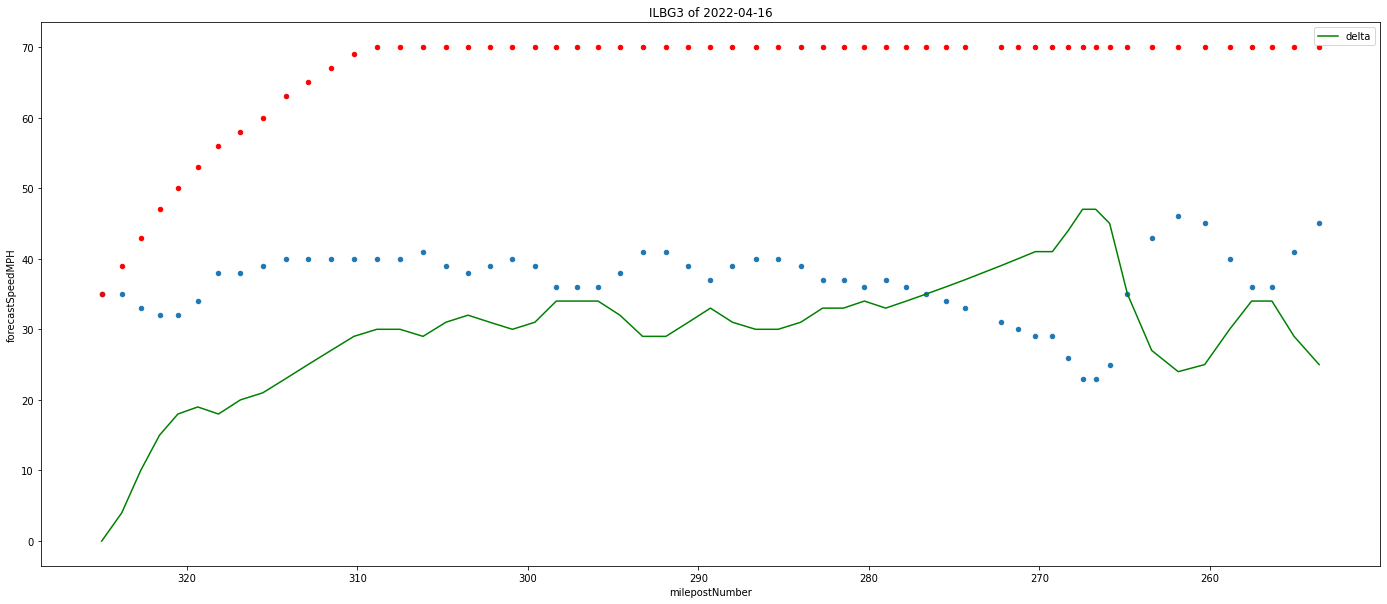

In [35]:
plotTrain(trains[1])

In [36]:
trains[:][1]

['ILBG3 of 2022-04-16',
        positionTime_beop  forecastSpeedMPH forecastTrackName  \
 0   2022-04-21T21:55:32Z                35              MT 2   
 1   2022-04-21T21:57:32Z                39              MT 2   
 2   2022-04-21T21:59:32Z                43              MT 2   
 3   2022-04-21T22:01:32Z                47              MT 2   
 4   2022-04-21T22:03:32Z                50              MT 2   
 5   2022-04-21T22:05:32Z                53              MT 2   
 6   2022-04-21T22:07:32Z                56              MT 2   
 7   2022-04-21T22:09:32Z                58              MT 2   
 8   2022-04-21T22:11:32Z                60              MT 2   
 9   2022-04-21T22:13:32Z                63              MT 2   
 10  2022-04-21T22:15:32Z                65              MT 2   
 11  2022-04-21T22:17:32Z                67              MT 2   
 12  2022-04-21T22:19:32Z                69              MT 2   
 13  2022-04-21T22:21:32Z                70              MT 2   
 

In [37]:
vals = trains[:][1].iloc[:,[1,5,8]].values.transpose()
np.pad(vals, [(0,0),(0, (60 - vals[0].size))], mode='constant', constant_values=(-1,-1))

AttributeError: ignored

# dfAll has actual readings by loco/train, 60 per, on

In [ ]:
# Define Utility Functions to build additional data rows

# Create a dataframe row holding a record of position on the train.
def createPositionHistoryFrame(positionHistory) -> dict:
    # The time that the train was at the specific milepost
    # Record the position time as seconds from epoch to use in regression model
    positionTime = positionHistory.get('positionTime')
    # How fast the train is traveling
    speedMPH = positionHistory.get('speedMPH')
    # Milepost location information
    milepostLocation = positionHistory.get('milepostLocation')
    # The unique identifier of the subdivision
    subdivisionId = milepostLocation.get('subdivisionId')
    # The unique identifier fo the milepost
    milepostNumber = milepostLocation.get('milepost').get('milepostNumber')

    # Construct new dataframe record
    return {'PositionTime': positionTime, 'SpeedMPH': speedMPH, 
    'SubdivisionId': subdivisionId, 'MilepostNumber':milepostNumber}

# Create a dataframe row for the identifier information of the trani
def createTrainIdFrame(trainId) -> dict:
    trainSymbol = trainId.get('trainSymbol')
    return {'TrainSymbol': trainSymbol}

# Create data frame for train detail
def createTrainDetailFrame(trainDetail) -> dict:
    maximumTrainSpeed = trainDetail.get('maximumTrainSpeed')
    loadedCarCount = trainDetail.get('loadedCarCount')
    emptyCarCount = trainDetail.get('emptyCarCount')
    trainLength = trainDetail.get('trainLength')
    trailingTonnage = trainDetail.get('trailingTonnage')

    # Construct new dataframe record
    return {'MaximumTrainSpeed': maximumTrainSpeed, 'LoadedCarCount': loadedCarCount, 
    'EmptyCarCount': emptyCarCount, 'TrainLength':trainLength, 'TrailingTonnage':trailingTonnage}

# Baseline #1 - measure the accuracy of the Physics model

### Part 1: L1 Norm and L2 Norm of Projected Speed versus Actual

In [ ]:
time = torch.arange(0,60).float(); time

In [ ]:
actuals = 

In [ ]:
def show_preds(predictionsTensor, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(predictionsTensor), color='red')
    ax.set_ylim(-300,100)